In [1]:
import os
import json
import sys

import sys
sys.path.append('../')  # Adding the core library

import maze
import importlib
importlib.reload(maze)

from maze.models import EfficientUNet

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

# Dataset

Create a construct which loads the data based in COCO format, with additional heatmaps stored separately, with same naming as the source image.

In [2]:
class FishHeatmapDataset(Dataset):
    def __init__(self, annotation_json, image_dir, heatmap_dir,
                 img_transform=None, joint_transform=None):
        self.samples = []
        self.img_transform = img_transform
        self.joint_transform = joint_transform

        with open(annotation_json, 'r') as f:
            coco_data = json.load(f)

        for img_info in coco_data['images']:
            file_name = img_info['file_name']
            img_path = os.path.join(image_dir, file_name)
            heatmap_path = os.path.join(heatmap_dir, os.path.splitext(file_name)[0] + '.npy')

            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            heatmap = np.load(heatmap_path)  # float32, assumed [0, 1]

            self.samples.append((image, heatmap, file_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, heatmap, _ = self.samples[idx]

        # Convert image to PIL (color image)
        image = Image.fromarray(image)
        heatmap_tensor = torch.from_numpy(heatmap).unsqueeze(0)  # [1, H, W]

        # Apply same random transforms to both
        if self.joint_transform:
            seed = np.random.randint(0, 10000)
            torch.manual_seed(seed)
            image = self.joint_transform(image)
            torch.manual_seed(seed)
            heatmap_tensor = self.joint_transform(heatmap_tensor)

        # Individual transforms (image normalization etc.)
        if self.img_transform:
            image = self.img_transform(image)

        # Clamp heatmap just in case and ensure float32
        heatmap_tensor = heatmap_tensor.clamp(0, 1).float()

        return image, heatmap_tensor

In [3]:
joint_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
])
joint_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Preload the data

We preload the data into DDR memory, as its not so big, and it speeds up the training process massively.

In [4]:
train_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_train.json",
    image_dir='../data/training/coco/images/',
    heatmap_dir='../data/training/coco/heatmaps/',
    joint_transform=joint_train,
    img_transform=img_transform,
)

val_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_val.json",
    image_dir='../data/training/coco/images/',
    heatmap_dir='../data/training/coco/heatmaps/',
    joint_transform=joint_val,
    img_transform=img_transform,
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

# Trainig

Let's setup our loss, optimizer etc.
1. **Loss**: we use Mean Squared Error (MSE) between predicted heatmap and target. It's simple and works well since both are smooth distribution
2. **Optimizer**: AdamW 
3. **LR scheduler**: ReduceLROnPlateau 

Later we run the training loop. 

In [5]:
# 1. Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 2. Initialize the model
model = EfficientUNet()

# Freeze first 3 stages of the encoder (enc1 to enc3)
for param in model.enc1.parameters():
    param.requires_grad = False
for param in model.enc2.parameters():
    param.requires_grad = False
for param in model.enc3.parameters():
    param.requires_grad = False

model = model.to(device)

# 3. Loss setup
mse_loss_fn = torch.nn.MSELoss()
alpha = 1.0

def get_centroid(heatmap):
    b, _, _, w = heatmap.shape
    flat_idx = torch.argmax(heatmap.view(b, -1), dim=1)
    y = flat_idx // w
    x = flat_idx % w
    return x.float(), y.float()

def centroid_distance_loss(pred, target):
    x_pred, y_pred = get_centroid(pred)
    x_gt, y_gt = get_centroid(target)
    dist = torch.sqrt((x_pred - x_gt)**2 + (y_pred - y_gt)**2 + 1e-8)
    return dist.mean()

# 4. Optimizer & scheduler (unchanged)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


Using device: cuda


In [ ]:
# 5. Training Loop Setup
epochs = 50
epoch_save_interval = 5

model_dir = '../data/models/efficientunet'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir, flush_secs=1)

best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for imgs, heatmaps in train_bar:
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = model(imgs)
        
        mse = mse_loss_fn(preds, heatmaps)
        cdist = centroid_distance_loss(preds, heatmaps)
        loss = mse + alpha * cdist

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
        train_bar.set_postfix(mse=mse.item(), cdist=cdist.item())

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
    with torch.no_grad():
        for imgs, heatmaps in val_bar:
            imgs = imgs.to(device)
            heatmaps = heatmaps.to(device)

            preds = model(imgs)

            mse = mse_loss_fn(preds, heatmaps)
            cdist = centroid_distance_loss(preds, heatmaps)
            loss = mse + alpha * cdist

            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())
            val_bar.set_postfix(mse=mse.item(), cdist=cdist.item())

    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'{model_dir}/best_model.pth')

    # Save model checkpoint every N epochs
    if (epoch + 1) % epoch_save_interval == 0:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))

writer.close()

Epoch 1/10 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Loss = 119.8033, Val Loss = 134.0394


Epoch 2/10 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2: Train Loss = 134.4045, Val Loss = 112.4626


Epoch 3/10 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3: Train Loss = 96.0768, Val Loss = 54.3721


Epoch 4/10 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4: Train Loss = 70.9424, Val Loss = 39.2253


Epoch 5/10 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5: Train Loss = 54.6991, Val Loss = 26.4296


Epoch 6/10 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6: Train Loss = 43.8057, Val Loss = 20.7514


Epoch 7/10 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7: Train Loss = 42.0447, Val Loss = 17.5429


Epoch 8/10 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8: Train Loss = 38.6871, Val Loss = 15.7663


Epoch 9/10 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9: Train Loss = 36.3425, Val Loss = 13.6168


Epoch 10/10 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10: Train Loss = 35.0064, Val Loss = 14.0995


# Model Validation

Now let's put model through numerous tests to see how well it performs.

In [7]:
# Load the best model for inference
model.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))

<All keys matched successfully>

In [8]:
results = []
total_distances = []
within_radius = {r: 0 for r in [3, 5, 10]}
n_samples = 0

model.eval()

with torch.no_grad():
    for imgs, heatmaps in tqdm(val_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = model(imgs)

        x_pred, y_pred = get_centroid(preds)
        x_gt, y_gt = get_centroid(heatmaps)

        x_pred = x_pred.cpu().numpy()
        y_pred = y_pred.cpu().numpy()

        x_gt = x_gt.cpu().numpy()
        y_gt = y_gt.cpu().numpy()

        for xp, yp, xg, yg in zip(x_pred, y_pred, x_gt, y_gt):
            dist = np.sqrt((xp - xg)**2 + (yp - yg)**2)
            total_distances.append(dist)
            for r in within_radius:
                if dist <= r:
                    within_radius[r] += 1
            n_samples += 1

        for i in range(imgs.size(0)):
            img = imgs[i].cpu()
            pred_hm = preds[i, 0].cpu()
            gt_hm = heatmaps[i, 0].cpu()

            xp, yp = x_pred[i], y_pred[i]
            xg, yg = x_gt[i], y_gt[i]
            dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)

            results.append({
                'image': img,
                'gt_heatmap': gt_hm,
                'pred_heatmap': pred_hm,
                'gt_centroid': (xg, yg),
                'pred_centroid': (xp, yp),
                'distance': dist,
            })

avg_dist = np.mean(total_distances)
print(f"\nAverage centroid distance: {avg_dist:.2f} px")

for r in sorted(within_radius):
    print(f"Within {r}px: {within_radius[r] / n_samples:.2%}")

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


Average centroid distance: 13.88 px
Within 3px: 4.42%
Within 5px: 10.15%
Within 10px: 46.32%


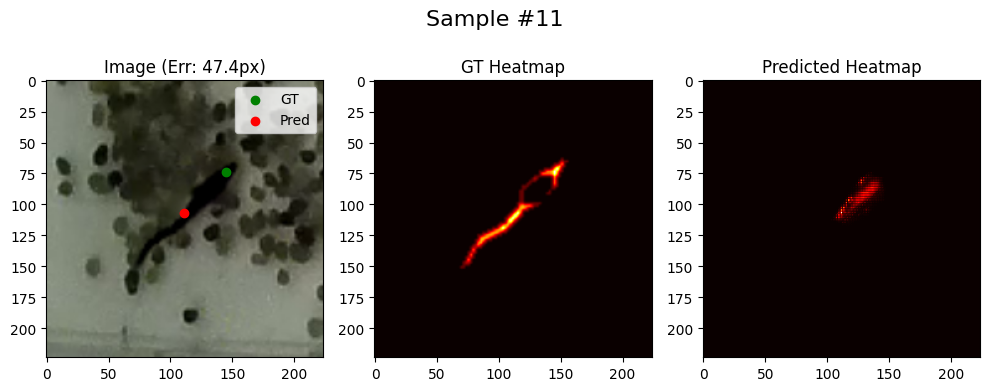

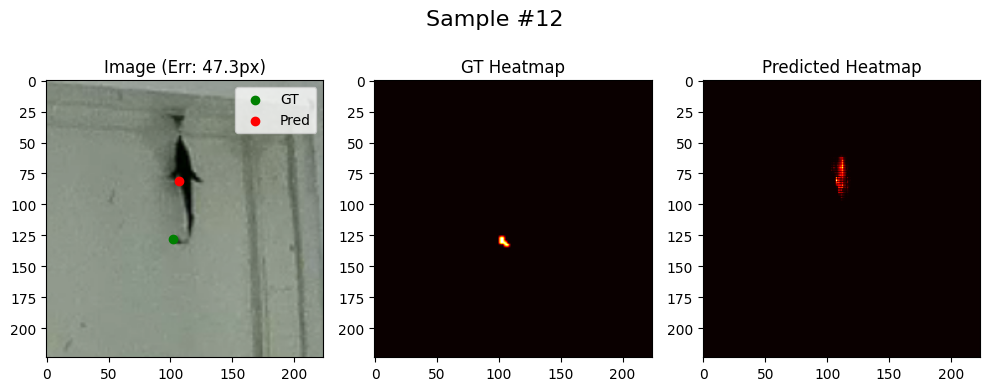

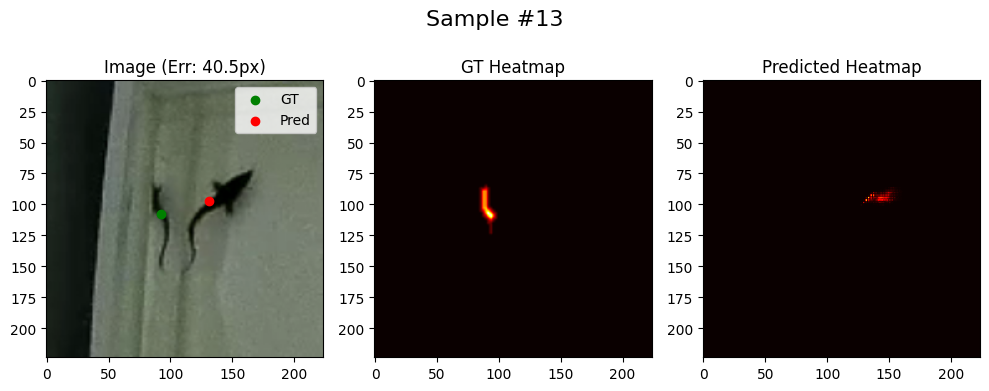

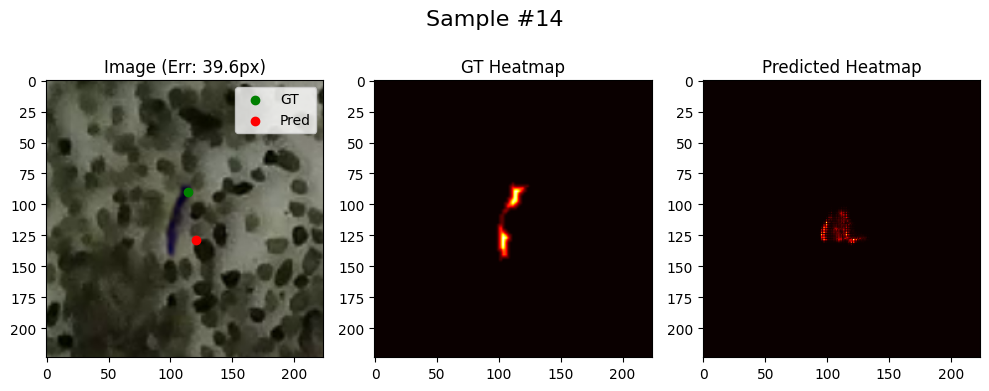

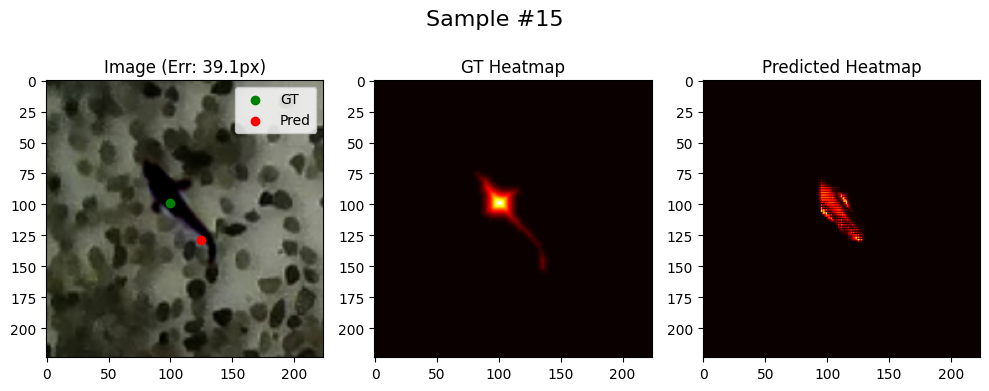

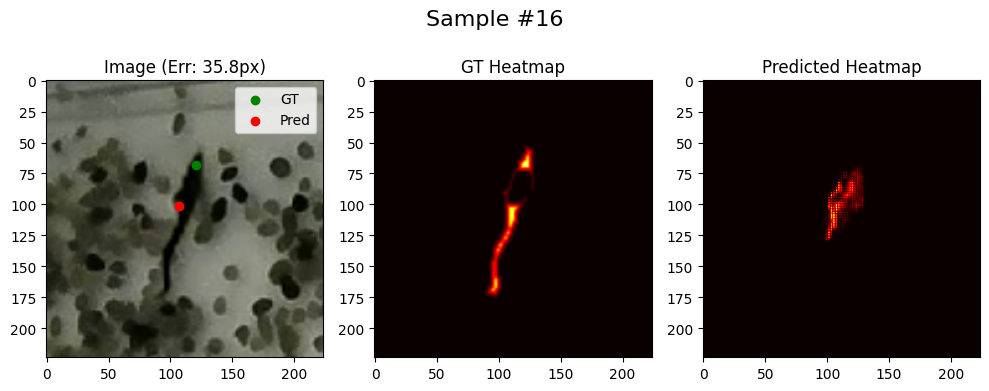

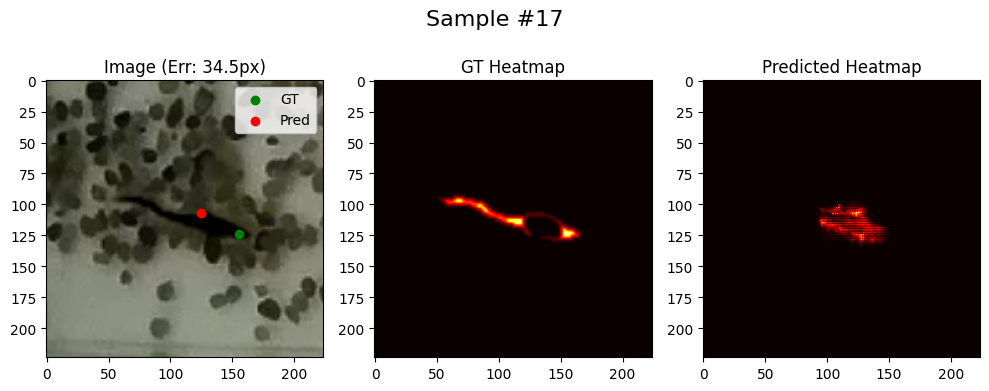

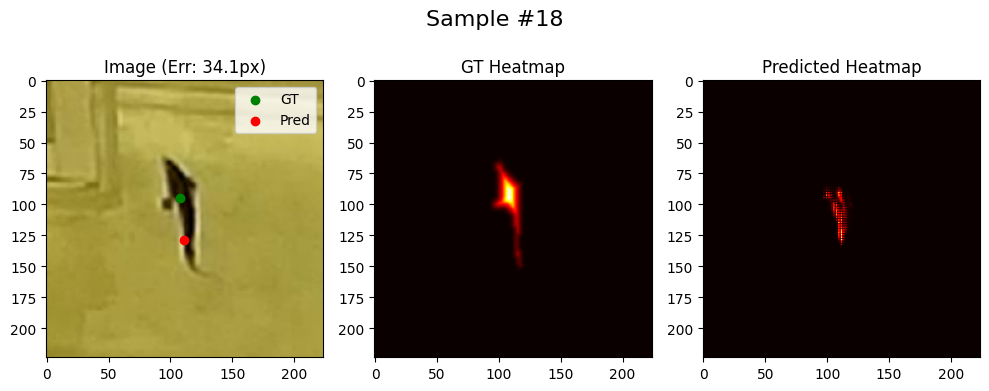

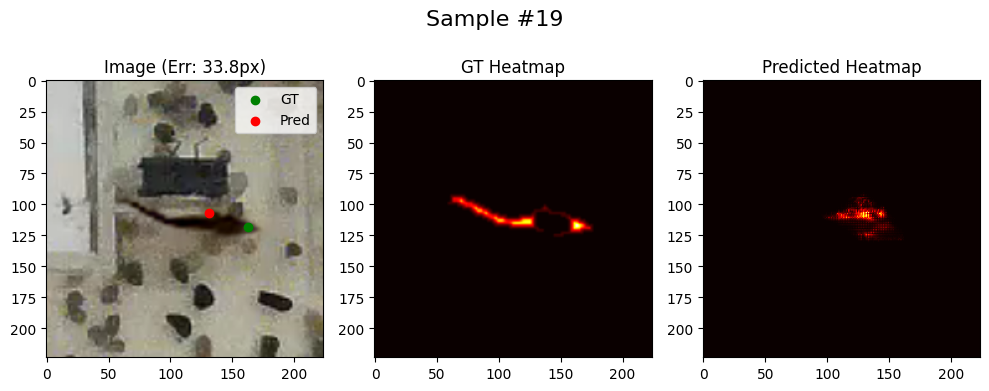

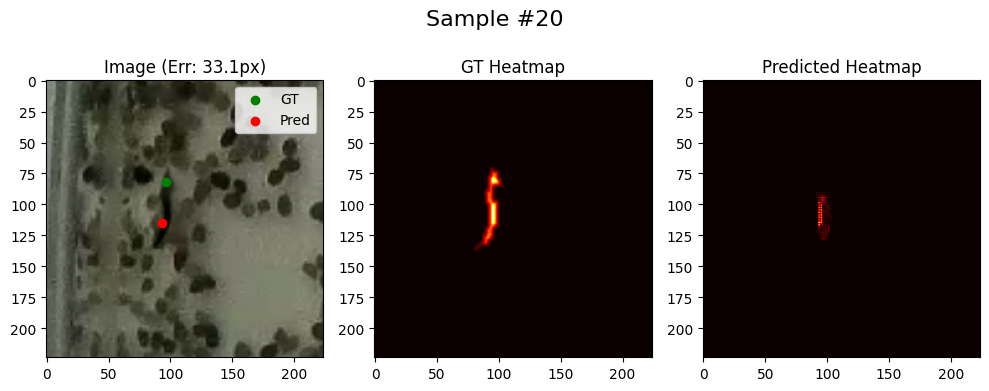

In [14]:
results.sort(key=lambda x: -x['distance'])  # descending


def show_sample(result, index=None):
    img = result['image']
    gt = result['gt_heatmap']
    pred = result['pred_heatmap']
    xg, yg = result['gt_centroid']
    xp, yp = result['pred_centroid']
    dist = result['distance']

    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_disp = img * std + mean
    img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(img_disp)
    axs[0].scatter([xg], [yg], c='green', label='GT')
    axs[0].scatter([xp], [yp], c='red', label='Pred')
    axs[0].set_title(f'Image (Err: {dist:.1f}px)')
    axs[0].legend()

    axs[1].imshow(gt.numpy(), cmap='hot')
    axs[1].set_title('GT Heatmap')

    axs[2].imshow(pred.numpy(), cmap='hot')
    axs[2].set_title('Predicted Heatmap')

    if index is not None:
        fig.suptitle(f"Sample #{index}", fontsize=16)

    plt.tight_layout()
    plt.show()

# Show top 5 worst predictions
for i in range(10, 20):
    show_sample(results[i], index=i+1)
